<a href="https://colab.research.google.com/github/therobinkay/gender_bias_2021/blob/main/Journal_Analysis_1_(GitHub).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import all necessary packages

import io
import pandas as pd
import os
import itertools
import numpy as np
import scipy.stats
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import networkx as nx
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cd "drive/My Drive"

In [ ]:
# read all necessary .csv files

data = pd.read_csv("drive/My Drive/codes/data.csv")
dp = pd.read_csv("drive/My Drive/codes/doipacs.csv")
cdata = pd.read_csv('drive/My Drive/codes/cdata.csv')
cb = pd.read_csv("drive/My Drive/codes/citationBara.csv")
cen = pd.read_csv("drive/My Drive/codes/cen.csv")

# Analyses


## 1. Order of Author Analysis

In [ ]:
# excluding alphabetically sorted papers

# splitting the authors by first, second, middle, last positions

first = data.query('is_alpha == False & order == 1')
second = data.query('is_alpha == False & order == 2 & is_last == False')
middle = data.query('is_alpha == False & order > 2 & is_last == False')
last = data.query('is_alpha == False & order != 1 & is_last == True')

In [ ]:
# calculating gender ratio of each position

print(first['gender'].value_counts(normalize=True))
print(second['gender'].value_counts(normalize=True))
print(middle['gender'].value_counts(normalize=True))
print(last['gender'].value_counts(normalize=True))

male      0.917101
female    0.082899
Name: gender, dtype: float64
male      0.911277
female    0.088723
Name: gender, dtype: float64
male      0.906659
female    0.093341
Name: gender, dtype: float64
male      0.91497
female    0.08503
Name: gender, dtype: float64


## 2. Productivity by Gender


In [12]:
data.head()

,doi,id,gender,order,numAuthor,is_last,is_alpha,year,articleType,journal
0,10.1103/PhysRevSeriesI.17.267,127898,male,2,2,True,False,1903,article,PRI
1,10.1103/PhysRev.5.269,127898,male,3,3,True,False,1915,article,PR
2,10.1103/PhysRevSeriesI.16.279,127898,male,2,2,True,False,1903,article,PRI
3,10.1103/PhysRevSeriesI.16.279,59048,male,1,2,False,False,1903,article,PRI
4,10.1103/PhysRevSeriesI.5.294,9710,male,1,2,False,False,1897,article,PRI


In [36]:
# Creating a DataFrame with productivity calculated
prod = data.groupby(['id', 'gender']).agg({'year': [min, max, 'count']})

prod['career_age'] = prod['year']['max'] - prod['year']['min']
prod['prod'] = prod['year']['count'] / (prod['career_age'])
prod = prod[prod['career_age'] != 0]

prod.sort_values([('year','count')], ascending=False).head()

# Dividing the DataFrame by gender
prod_m = prod.xs('male', level='gender')
prod_fm = prod.xs('female', level='gender')

In [38]:
#ks test (two-tailed)
from scipy.stats import ks_2samp
print(ks_2samp(prod_m2['prod'], prod_fm2['prod']))

#ks test: male > female
print(ks_2samp(prod_m2['prod'], prod_fm2['prod'], alternative='greater'))

#ks test: male < female
print(ks_2samp(prod_m2['prod'], prod_fm2['prod'], alternative='less'))

Ks_2sampResult(statistic=0.0329418537762845, pvalue=0.000127997328482532)
Ks_2sampResult(statistic=0.0329418537762845, pvalue=6.244757804870422e-05)
Ks_2sampResult(statistic=0.019882369577186365, pvalue=0.029229651385167425)


In [37]:
# finding where the biggest difference occurs

def ks_2samp_x(data1, data2, alternative="two-sided"):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]

    data_all = np.concatenate([data1, data2])
    # using searchsorted solves equal data problem
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2
    cddiffs = cdf1 - cdf2
    minS = np.argmin(cddiffs)   # ks_2samp uses np.min or np.max respectively 
    maxS = np.argmax(cddiffs)   # now we get instead the index in data_all
    alt2Dvalue = {'less': minS, 'greater': maxS, 'two-sided': max(minS, maxS)}
    d_arg = alt2Dvalue[alternative]
    return data_all[d_arg]

print(ks_2samp_x(prod_m['prod'], prod_fm['prod']))
print(ks_2samp_x(prod_m['prod'], prod_fm['prod'], alternative="greater"))
print(ks_2samp_x(prod_m['prod'], prod_fm['prod'], alternative="less"))

2.0
0.4857142857142857
2.0


## 3. Dropout Authors by Career Age
Don't include the authors who have not written anything before 1999.

(annual year is only showing less accurate dropout)

(0.0, 0.2)

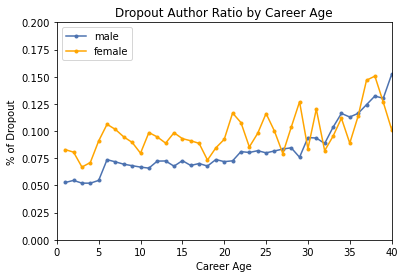

In [53]:
# exclude authors who enter APS publication after 2004
# create (JADIDI) scatterplot of dropout authors by career age

gb = prod[prod['year']['min'] < 2004].groupby(['gender', 'career_age'])['career_age'].count()

gb_m = gb['male'].sort_index(ascending=False)
gb_fm = gb['female'].sort_index(ascending=False)

(gb_m/gb_m.cumsum()).iloc[::-1].plot(style='.-')
(gb_fm/gb_fm.cumsum()).iloc[::-1].plot(style='.-',color='orange')

plt.title('Dropout Author Ratio by Career Age')
plt.legend(('male', 'female'), loc='upper left')
plt.xlabel('Career Age')
plt.xlim(0,40)
plt.ylabel('% of Dropout')
plt.ylim(0, 0.2)

## 4. Frequently-cited Papers Analysis
Only consider primary authors.

How many of the top 10, 20, 30% belong to men first articles, female first articles?

Are those statistically significant? Expected?

If this is not expected, why? Productivity?

In [ ]:
# exclude alphabetically ordered papers
na = data[data['is_alpha'] == False]

# only consider primary authors
na_p = na[na['order'] == 1]

# calculate degree centrality per paper
vc = cb['cited_doi'].value_counts()
cb_sub = vc[vc.to_numpy() > 0].to_frame()

# create a DataFrame with degree centrality
cited = pd.merge(cb_sub, na_p, left_index = True, right_on = 'doi')

# split the DataFrame by gender
cited_m = cited[cited['gender'] == 'male']
cited_fm = cited[cited['gender'] == 'female']

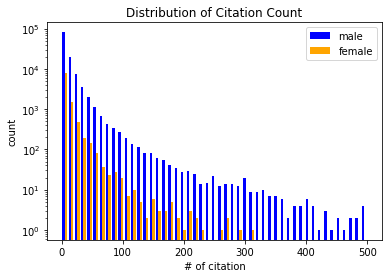

In [ ]:
# create a comparative histogram for degree centrality by gender

plt.style.use('seaborn-deep')

x = cited_m['cited_doi']
y = cited_fm['cited_doi']

bins = np.linspace(0, 500, 50)

plt.hist([x, y], bins, label=['male', 'female'], color=('blue','orange'))
plt.yscale('log')
plt.legend(loc='upper right')
plt.title("Distribution of Citation Count")
plt.xlabel('# of citation')
plt.ylabel('count')
# plt.xlim(xmin=0)
plt.show()

## 4b. Frequently-cited Papers Analysis 2

In [ ]:
# similar DataFrame setup to Section 4

na = data[data['is_alpha'] == False]
na_p = na[na['order'] == 1]

vc = cb['cited_doi'].value_counts()
cb_sub = vc[vc.to_numpy() > 0].to_frame()

cited = pd.merge(cb_sub, na_p, left_index = True, right_on = 'doi')

cited_m = cited[cited['gender'] == 'male']
cited_fm = cited[cited['gender'] == 'female']

Text(0, 0.5, 'Proportion of Female Primary Authors')

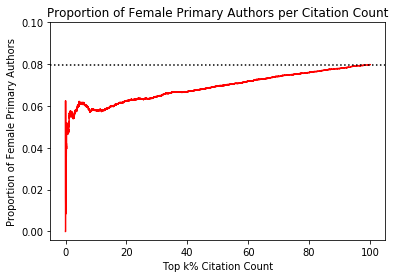

In [ ]:
# Comparative graph for actual female proportion vs. expected female proportion

cited_gender = cited['gender'].to_numpy()
cumulate_cited_gender = np.cumsum(cited_gender == "female")

plt.plot((np.arange(len(cited))*100)/len(cited), cumulate_cited_gender/np.arange(1, len(cited)+1), color='red')
plt.axhline(y=len(cited[cited['gender'] == 'female'])/len(cited), color='black', linestyle='dotted')

plt.title("Proportion of Female Primary Authors per Citation Count")
plt.xlabel("Top k% Citation Count")
plt.ylim(ymax=0.1)
plt.ylabel("Proportion of Female Primary Authors")

## 5a. Self-citation Analysis (general)

In [ ]:
# create a DataFrame with self-citing authors
sc_list = cdata[cdata['citing_id'] == cdata['cited_id']]

# split the DataFrame by gender
sc_m = sc_list[sc_list['citing_gender'] == 'male']
sc_fm = sc_list[sc_list['citing_gender'] == 'female']

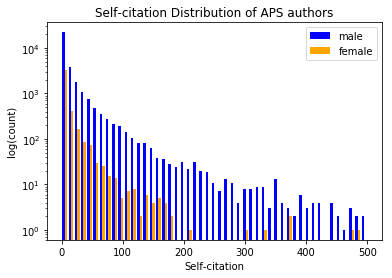

In [ ]:
# create a comparative histogram for self-citation by gender
plt.style.use('seaborn-deep')

x = sc_m['citing_id'].value_counts()
y = sc_fm['citing_id'].value_counts()
bins = np.linspace(0, 500, 50) #remove outliers

plt.hist([x, y], bins, label=['male', 'female'], color=('blue','orange'))
plt.yscale('log')
plt.legend(loc='upper right')
plt.title('Self-citation Distribution of APS authors')
plt.xlabel('Self-citation')
plt.ylabel('log(count)')
plt.show()

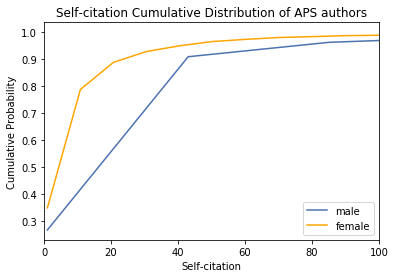

In [ ]:
# CDF for self-citation per gender

import statsmodels.api as sm

sample = sc_m['citing_id'].value_counts()
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(x,y)

sample_2 = sc_fm['citing_id'].value_counts()
ecdf = sm.distributions.ECDF(sample_2)

x_2 = np.linspace(min(sample_2), max(sample_2))
y_2 = ecdf(x_2)
plt.plot(x_2,y_2, color='orange')

plt.title('Self-citation Cumulative Distribution of APS authors')
plt.legend(('male', 'female'), loc='lower right')
plt.xlabel('Self-citation')
plt.xlim(0,100)
plt.ylabel('Cumulative Probability')
# plt.ylim(0,0.35)
plt.show()

## 5b. Self-citation Analysis (by year)

In [ ]:
# self-citing author dataframes, by gender
sc_list = cdata[cdata['citing_id'] == cdata['cited_id']]
sc_m = sc_list[sc_list['citing_gender'] == 'male']
sc_fm = sc_list[sc_list['citing_gender'] == 'female']

# group data points by publication year
msc = sc_m.groupby(['citing_year'])['citing_year'].count()
fmsc = sc_fm.groupby(['citing_year'])['citing_year'].count()

# create overall self-citing author dataframes for ratio calculation
cdata_m = cdata[cdata['citing_gender'] == 'male']
cdata_fm = cdata[cdata['citing_gender'] == 'female']
mcdata = cdata_m.groupby(['citing_year'])['citing_year'].count()
fmcdata = cdata_fm.groupby(['citing_year'])['citing_year'].count()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 0.15)

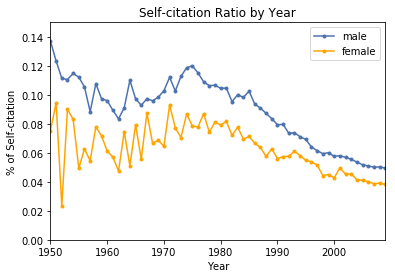

In [ ]:
# create a self-citation ratio plot by year
(msc/mcdata).plot(style='.-')
(fmsc/fmcdata).plot(style='.-',color='orange')

plt.title('Self-citation Ratio by Year')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.15)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


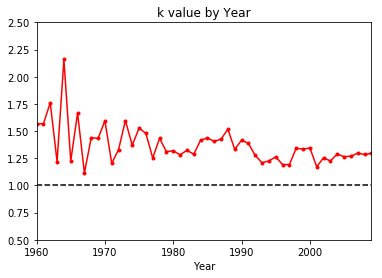

In [ ]:
# create overall self-citing author dataframes for ratio calculation with 0s
cdatacit = cdata.groupby(['citing_year'])['citing_year'].count()
cdatacit[np.isnan(cdatacit)] = 0
mcdata = cdata_m.groupby(['citing_year'])['citing_year'].count()
mcdata[np.isnan(mcdata)] = 0
fmcdata = cdata_fm.groupby(['citing_year'])['citing_year'].count()
fmcdata[np.isnan(fmcdata)] = 0

# create self-citing author by year dataframes for ratio calculation with 0s
sccit = sc_list.groupby(['citing_year'])['citing_year'].count()
sccit[np.isnan(sccit)] = 0
msc = sc_m.groupby(['citing_year'])['citing_year'].count()
msc[np.isnan(msc)] = 0
fmsc = sc_fm.groupby(['citing_year'])['citing_year'].count()
fmsc[np.isnan(fmsc)] = 0

# calculate k-value from Section 5.2
k1 = ((msc/sccit)/(fmsc/sccit))
k2 = ((fmcdata/cdatacit)/(mcdata/cdatacit))
k = k1*k2

# create k-value plot
k.plot(style='.-', color='red')

plt.title('k value by Year')
plt.xlabel('Year')
plt.xlim(xmin=1960)
plt.ylabel('k')
plt.ylim(ymin=0.5,ymax=2.5)
plt.hlines(1,xmin=1903,xmax=2009,linestyles='dashed')

## 5c. Self-citation Analysis (by Author Number)

In [ ]:
# create self-citation dataframes
cdata_m = cdata[cdata['citing_gender'] == 'male']
cdata_fm = cdata[cdata['citing_gender'] == 'female']
sc_list = cdata[cdata['citing_id'] == cdata['cited_id']]
sc_m = sc_list[sc_list['citing_gender'] == 'male']
sc_fm = sc_list[sc_list['citing_gender'] == 'female']

# observe paper distribution by number of authors
mcdata = cdata_m.groupby(['citing_numAuthor'])['citing_numAuthor'].count()
fmcdata = cdata_fm.groupby(['citing_numAuthor'])['citing_numAuthor'].count()
msc = sc_m.groupby(['citing_numAuthor'])['citing_numAuthor'].count()
fmsc = sc_fm.groupby(['citing_numAuthor'])['citing_numAuthor'].count()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


Text(0, 0.5, '% Self-citation')

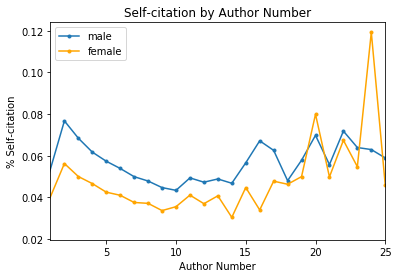

In [ ]:
# create a self-citation plot by number of author
(msc/mcdata).plot(style='.-')
(fmsc/fmcdata).plot(style='.-',color='orange')

plt.title('Self-citation by Author Number')
plt.legend(('male', 'female'), loc='upper left')
plt.xlabel('Author Number')
plt.xlim(xmin=1)
plt.ylabel('% Self-citation')

## 5d. Self-citation Analysis (by PACS & Year)

In [ ]:
# create self-citation dataframes

cdata_m = cdata[cdata['citing_gender'] == 'male']
cdata_fm = cdata[cdata['citing_gender'] == 'female']
sc_list = cdata[cdata['citing_id'] == cdata['cited_id']]
sc_m = sc_list[sc_list['citing_gender'] == 'male']
sc_fm = sc_list[sc_list['citing_gender'] == 'female']

In [ ]:
# divide the sample population dataframe by PACS and gender

cdata_m_0 = cdata_m[cdata_m['citing_0'] == True]
cdata_m_1 = cdata_m[cdata_m['citing_1'] == True]
cdata_m_2 = cdata_m[cdata_m['citing_2'] == True]
cdata_m_3 = cdata_m[cdata_m['citing_3'] == True]
cdata_m_4 = cdata_m[cdata_m['citing_4'] == True]
cdata_m_5 = cdata_m[cdata_m['citing_5'] == True]
cdata_m_6 = cdata_m[cdata_m['citing_6'] == True]
cdata_m_7 = cdata_m[cdata_m['citing_7'] == True]
cdata_m_8 = cdata_m[cdata_m['citing_8'] == True]
cdata_m_9 = cdata_m[cdata_m['citing_9'] == True]

cdata_fm_0 = cdata_fm[cdata_fm['citing_0'] == True]
cdata_fm_1 = cdata_fm[cdata_fm['citing_1'] == True]
cdata_fm_2 = cdata_fm[cdata_fm['citing_2'] == True]
cdata_fm_3 = cdata_fm[cdata_fm['citing_3'] == True]
cdata_fm_4 = cdata_fm[cdata_fm['citing_4'] == True]
cdata_fm_5 = cdata_fm[cdata_fm['citing_5'] == True]
cdata_fm_6 = cdata_fm[cdata_fm['citing_6'] == True]
cdata_fm_7 = cdata_fm[cdata_fm['citing_7'] == True]
cdata_fm_8 = cdata_fm[cdata_fm['citing_8'] == True]
cdata_fm_9 = cdata_fm[cdata_fm['citing_9'] == True]

sc_m_0 = sc_m[sc_m['citing_0'] == True]
sc_m_1 = sc_m[sc_m['citing_1'] == True]
sc_m_2 = sc_m[sc_m['citing_2'] == True]
sc_m_3 = sc_m[sc_m['citing_3'] == True]
sc_m_4 = sc_m[sc_m['citing_4'] == True]
sc_m_5 = sc_m[sc_m['citing_5'] == True]
sc_m_6 = sc_m[sc_m['citing_6'] == True]
sc_m_7 = sc_m[sc_m['citing_7'] == True]
sc_m_8 = sc_m[sc_m['citing_8'] == True]
sc_m_9 = sc_m[sc_m['citing_9'] == True]

sc_fm_0 = sc_fm[sc_fm['citing_0'] == True]
sc_fm_1 = sc_fm[sc_fm['citing_1'] == True]
sc_fm_2 = sc_fm[sc_fm['citing_2'] == True]
sc_fm_3 = sc_fm[sc_fm['citing_3'] == True]
sc_fm_4 = sc_fm[sc_fm['citing_4'] == True]
sc_fm_5 = sc_fm[sc_fm['citing_5'] == True]
sc_fm_6 = sc_fm[sc_fm['citing_6'] == True]
sc_fm_7 = sc_fm[sc_fm['citing_7'] == True]
sc_fm_8 = sc_fm[sc_fm['citing_8'] == True]
sc_fm_9 = sc_fm[sc_fm['citing_9'] == True]

mcdata_0 = cdata_m_0.groupby(['citing_year'])['citing_year'].count()
mcdata_1 = cdata_m_1.groupby(['citing_year'])['citing_year'].count()
mcdata_2 = cdata_m_2.groupby(['citing_year'])['citing_year'].count()
mcdata_3 = cdata_m_3.groupby(['citing_year'])['citing_year'].count()
mcdata_4 = cdata_m_4.groupby(['citing_year'])['citing_year'].count()
mcdata_5 = cdata_m_5.groupby(['citing_year'])['citing_year'].count()
mcdata_6 = cdata_m_6.groupby(['citing_year'])['citing_year'].count()
mcdata_7 = cdata_m_7.groupby(['citing_year'])['citing_year'].count()
mcdata_8 = cdata_m_8.groupby(['citing_year'])['citing_year'].count()
mcdata_9 = cdata_m_9.groupby(['citing_year'])['citing_year'].count()

fmcdata_0 = cdata_fm_0.groupby(['citing_year'])['citing_year'].count()
fmcdata_1 = cdata_fm_1.groupby(['citing_year'])['citing_year'].count()
fmcdata_2 = cdata_fm_2.groupby(['citing_year'])['citing_year'].count()
fmcdata_3 = cdata_fm_3.groupby(['citing_year'])['citing_year'].count()
fmcdata_4 = cdata_fm_4.groupby(['citing_year'])['citing_year'].count()
fmcdata_5 = cdata_fm_5.groupby(['citing_year'])['citing_year'].count()
fmcdata_6 = cdata_fm_6.groupby(['citing_year'])['citing_year'].count()
fmcdata_7 = cdata_fm_7.groupby(['citing_year'])['citing_year'].count()
fmcdata_8 = cdata_fm_8.groupby(['citing_year'])['citing_year'].count()
fmcdata_9 = cdata_fm_9.groupby(['citing_year'])['citing_year'].count()

msc_0 = sc_m_0.groupby(['citing_year'])['citing_year'].count()
msc_1 = sc_m_1.groupby(['citing_year'])['citing_year'].count()
msc_2 = sc_m_2.groupby(['citing_year'])['citing_year'].count()
msc_3 = sc_m_3.groupby(['citing_year'])['citing_year'].count()
msc_4 = sc_m_4.groupby(['citing_year'])['citing_year'].count()
msc_5 = sc_m_5.groupby(['citing_year'])['citing_year'].count()
msc_6 = sc_m_6.groupby(['citing_year'])['citing_year'].count()
msc_7 = sc_m_7.groupby(['citing_year'])['citing_year'].count()
msc_8 = sc_m_8.groupby(['citing_year'])['citing_year'].count()
msc_9 = sc_m_9.groupby(['citing_year'])['citing_year'].count()

fmsc_0 = sc_fm_0.groupby(['citing_year'])['citing_year'].count()
fmsc_1 = sc_fm_1.groupby(['citing_year'])['citing_year'].count()
fmsc_2 = sc_fm_2.groupby(['citing_year'])['citing_year'].count()
fmsc_3 = sc_fm_3.groupby(['citing_year'])['citing_year'].count()
fmsc_4 = sc_fm_4.groupby(['citing_year'])['citing_year'].count()
fmsc_5 = sc_fm_5.groupby(['citing_year'])['citing_year'].count()
fmsc_6 = sc_fm_6.groupby(['citing_year'])['citing_year'].count()
fmsc_7 = sc_fm_7.groupby(['citing_year'])['citing_year'].count()
fmsc_8 = sc_fm_8.groupby(['citing_year'])['citing_year'].count()
fmsc_9 = sc_fm_9.groupby(['citing_year'])['citing_year'].count()

In [ ]:
## Create plots for self-citations by PACS

# PACS 00
plt.figure(1)

(msc_0/mcdata_0).plot(style='.-')
(fmsc_0/fmcdata_0).plot(style='.-',color='orange')

plt.title('General Physics')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

#-------------------------------------------------------------------------------
# PACS 10
plt.figure(2)

(msc_1/mcdata_1).plot(style='.-')
(fmsc_1/fmcdata_1).plot(style='.-',color='orange')

plt.title('The Physics of Elementary Particles and Fields')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

#-------------------------------------------------------------------------------
# PACS 20
plt.figure(3)

(msc_2/mcdata_2).plot(style='.-')
(fmsc_2/fmcdata_2).plot(style='.-',color='orange')

plt.title('Nuclear Physics')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

#-------------------------------------------------------------------------------
# PACS 30
plt.figure(4)

(msc_3/mcdata_3).plot(style='.-')
(fmsc_3/fmcdata_3).plot(style='.-',color='orange')

plt.title('Atomic and Molecular Physics')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

#-------------------------------------------------------------------------------
# PACS 40
plt.figure(5)

(msc_4/mcdata_4).plot(style='.-')
(fmsc_4/fmcdata_4).plot(style='.-',color='orange')

plt.title('Electromagnetism, Optics, Acoustics, Heat Transfer,\n Classical Mechanics, and Fluid Dynamics')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

#-------------------------------------------------------------------------------
# PACS 50
plt.figure(6)

(msc_5/mcdata_5).plot(style='.-')
(fmsc_5/fmcdata_5).plot(style='.-',color='orange')

plt.title('Physics of Gases, Plasmas, and Electric Discharges')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

#-------------------------------------------------------------------------------
# PACS 60
plt.figure(7)

(msc_6/mcdata_6).plot(style='.-')
(fmsc_6/fmcdata_6).plot(style='.-',color='orange')

plt.title('Condensed Matter: Structural, Mechanical,\n and Thermal Properties')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

#-------------------------------------------------------------------------------
# PACS 70
plt.figure(8)

(msc_7/mcdata_7).plot(style='.-')
(fmsc_7/fmcdata_7).plot(style='.-',color='orange')

plt.title('Condensed Matter: Electronic Structure, Electrical,\n Magnetic, and Optical Properties')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

#-------------------------------------------------------------------------------
# PACS 80
plt.figure(9)

(msc_8/mcdata_8).plot(style='.-')
(fmsc_8/fmcdata_8).plot(style='.-',color='orange')

plt.title('Interdisciplinary Physics and Related Areas\n of Science and Technology')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

#-------------------------------------------------------------------------------
# PACS 90
plt.figure(10)

(msc_9/mcdata_9).plot(style='.-')
(fmsc_9/fmcdata_9).plot(style='.-',color='orange')

plt.title('Geophysics, Astronomy, and Astrophysics')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

## 6 PageRank Centrality

In [ ]:
# apply nx.graph to citation relationship network
Graphtype = nx.DiGraph()

C = nx.from_pandas_edgelist(cen, source='citing_doi', target='cited_doi', create_using=Graphtype)
print(nx.info(C))

Name: 
Type: DiGraph
Number of nodes: 144813
Number of edges: 703005
Average in degree:   4.8546
Average out degree:   4.8546


In [ ]:
# assign PageRank centrality to each paper
pr = nx.pagerank(C)

# create a centrality dataframe
prs = pd.DataFrame()
prs['doi'] = pr.keys()
prs['centrality'] = pr.values()

In [ ]:
# observe author id & gender (primary author)
nodedata = data[data['is_alpha'] == False]
nodedata = nodedata[nodedata['order'] == 1]
nodedata = nodedata.drop(['order', 'numAuthor',	'is_last',	'is_alpha',	'year',	'articleType',	'journal', 'id'], axis=1)
nodedata = nodedata.reset_index()
nodedata.columns = ['id', 'Label', 'Gender']
nodedata.head()

# merge and create a dataframe: id, gender, PageRank centrality
prs = prs.merge(nodedata, left_on='doi', right_on='Label', how='left')
prs = prs.drop(['doi', 'Label'], axis=1)
prs = prs[['id', 'Gender', 'centrality']]

# split the dataframe by gender
prs_m = prs[prs['Gender'] == 'male']
prs_fm = prs[prs['Gender'] == 'female']

In [ ]:
# create a comparative histogram for PageRank centrality by gender
plt.style.use('seaborn-deep')
bins = np.linspace(0, 0.0015, 50)

plt.hist([prs_m['centrality'], prs_fm['centrality']], bins, label=['male', 'female'], color=['blue','orange'])

plt.title("PageRank Centrality for Primary Authors")
plt.legend(loc='upper right')
plt.xlabel('Centrality')
plt.yscale('log')
plt.ylabel('log(count)')
plt.show()

Text(0, 0.5, 'Proportion of Female Primary Authors')

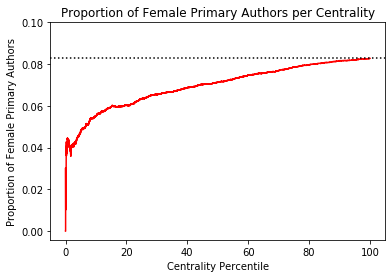

In [ ]:
# Comparative graph for actual female proportion vs. expected female proportion

prs_gender = prs['Gender'].to_numpy()
cumulate_prs_gender = np.cumsum(prs_gender == "female")

plt.plot((np.arange(len(prs))*100)/len(prs), cumulate_prs_gender/np.arange(1, len(prs)+1), color='red')
plt.axhline(y=0.08274119036274367, color='black', linestyle='dotted')

plt.title("Proportion of Female Primary Authors per Centrality")
plt.xlabel("top k% Centrality")
plt.ylim(ymax=0.1)
plt.ylabel("Proportion of Female Primary Authors")